<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter13/Chapter_13_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade fastai
from fastai.vision.all import *
from fastai import *

     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
top_edge = tensor([[-1,-1,-1],
                  [0,0,0],
                  [1,1,1]]).float()

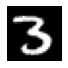

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3, cmap = 'gray')

In [4]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[:10, :20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


For the top edge of the 3, we have the values above the middle row being 0 (so no contribution) and the values on the bottom row being high positive numbers so overall we get a high positive number from the multiplication.
For the bottom edge, the opposite is true.

In [5]:
(im3_t[4:7, 6:9]*top_edge).sum()

tensor(762.)

In [6]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2]*kernel).sum()

In [7]:
apply_kernel(5, 7, top_edge)

tensor(762.)

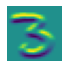

In [8]:
top_edge3 = tensor([[apply_kernel(row, col, top_edge) for col in range(1,27)] for row in range(1,27)])
show_image(top_edge3)

In [9]:
left_edge = tensor([[-1, 0, 1],
                    [-1,0,1],
                    [-1,0,1]])

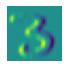

In [10]:
left_edge3 = tensor([[apply_kernel(row, col, left_edge) for col in range(1,27)] for row in range(1,27)])
show_image(left_edge3)

In [11]:
diag1_edge = tensor([[0,-1,1],
                     [-1,1,0],
                     [1,0,0]])

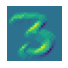

In [12]:
diag1 = tensor([[apply_kernel(row, col, diag1_edge) for col in range(1,27)] for row in range(1,27)])
show_image(diag1)

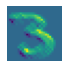

In [13]:
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]])
diag2 = tensor([[apply_kernel(row, col, diag2_edge) for col in range(1,27)] for row in range(1,27)])
show_image(diag2)

In [21]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [15]:
mnist = DataBlock((ImageBlock(cls = PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)
dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

(64, 1, 28, 28)

In [16]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [ ]:
!pip install nbdev
doc(ImageBlock)

In [22]:
edge_kernels = edge_kernels.unsqueeze(1)
edge_kernels.shape
# We need to add an extra dimension here because torch expects a 4 dimensional tensor

torch.Size([4, 1, 3, 3])

In [24]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

(64, 4, 26, 26)

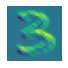

In [28]:
show_image(batch_features[0,3])

In [29]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [38]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding = 1), #Does the 30 here stand for how many convolutions of this size I want to run on my data? Probably
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)
#Conv2d has 1 channel and will apply the conv to all the pixels of the input. But what about the output?

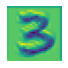

In [44]:
show_image(broken_cnn(xb)[0,0])

In [45]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res